In [1]:
%pylab notebook
%config InlineBackend.figure_format = 'retina'
import torch
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from neurodiffeq.ode import solve_system
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.conditions import IVP   # the initial condition

from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [3]:
# gravitational constant of the central body
gm = 6.665e-07

In [4]:
# the initial condition for a circular orbit, according to `https://en.wikipedia.org/wiki/Circular_orbit`
R = 10
V = sqrt(gm / R)
peroid = 2*pi*sqrt(R**3 / gm)
R, V, peroid

(10, 0.00025816661286851174, 243377.14460311376)

In [5]:
y0 = np.array([
    R, 0, 0,
    0, V, 0,
])

In [6]:
# the start and and end time
t0 = 0
tn = t0 + 86400 * 3
step = 60
ts = np.arange(t0, tn+.1*step, step)

# Equation of motion for a celestial object

$$
\frac{d^2 \vec{r}}{d t^2} = - \frac{GM}{r^3} \vec{r}
$$ 

# Numerical method to solve the ODE

In [7]:
def eq_of_mo_scipy(t, state):
    r_vec = state[:3]
    r = norm(r_vec)
    acc = - gm * r_vec / r ** 3
    state_dot = np.concatenate([state[3:], acc])
    return state_dot

In [8]:
%%time
res = solve_ivp(eq_of_mo_scipy, (t0, tn), y0, atol=1e-11, t_eval=ts, rtol=1e-11)

CPU times: user 39.9 ms, sys: 1.92 ms, total: 41.9 ms
Wall time: 41.6 ms


<IPython.core.display.Javascript object>


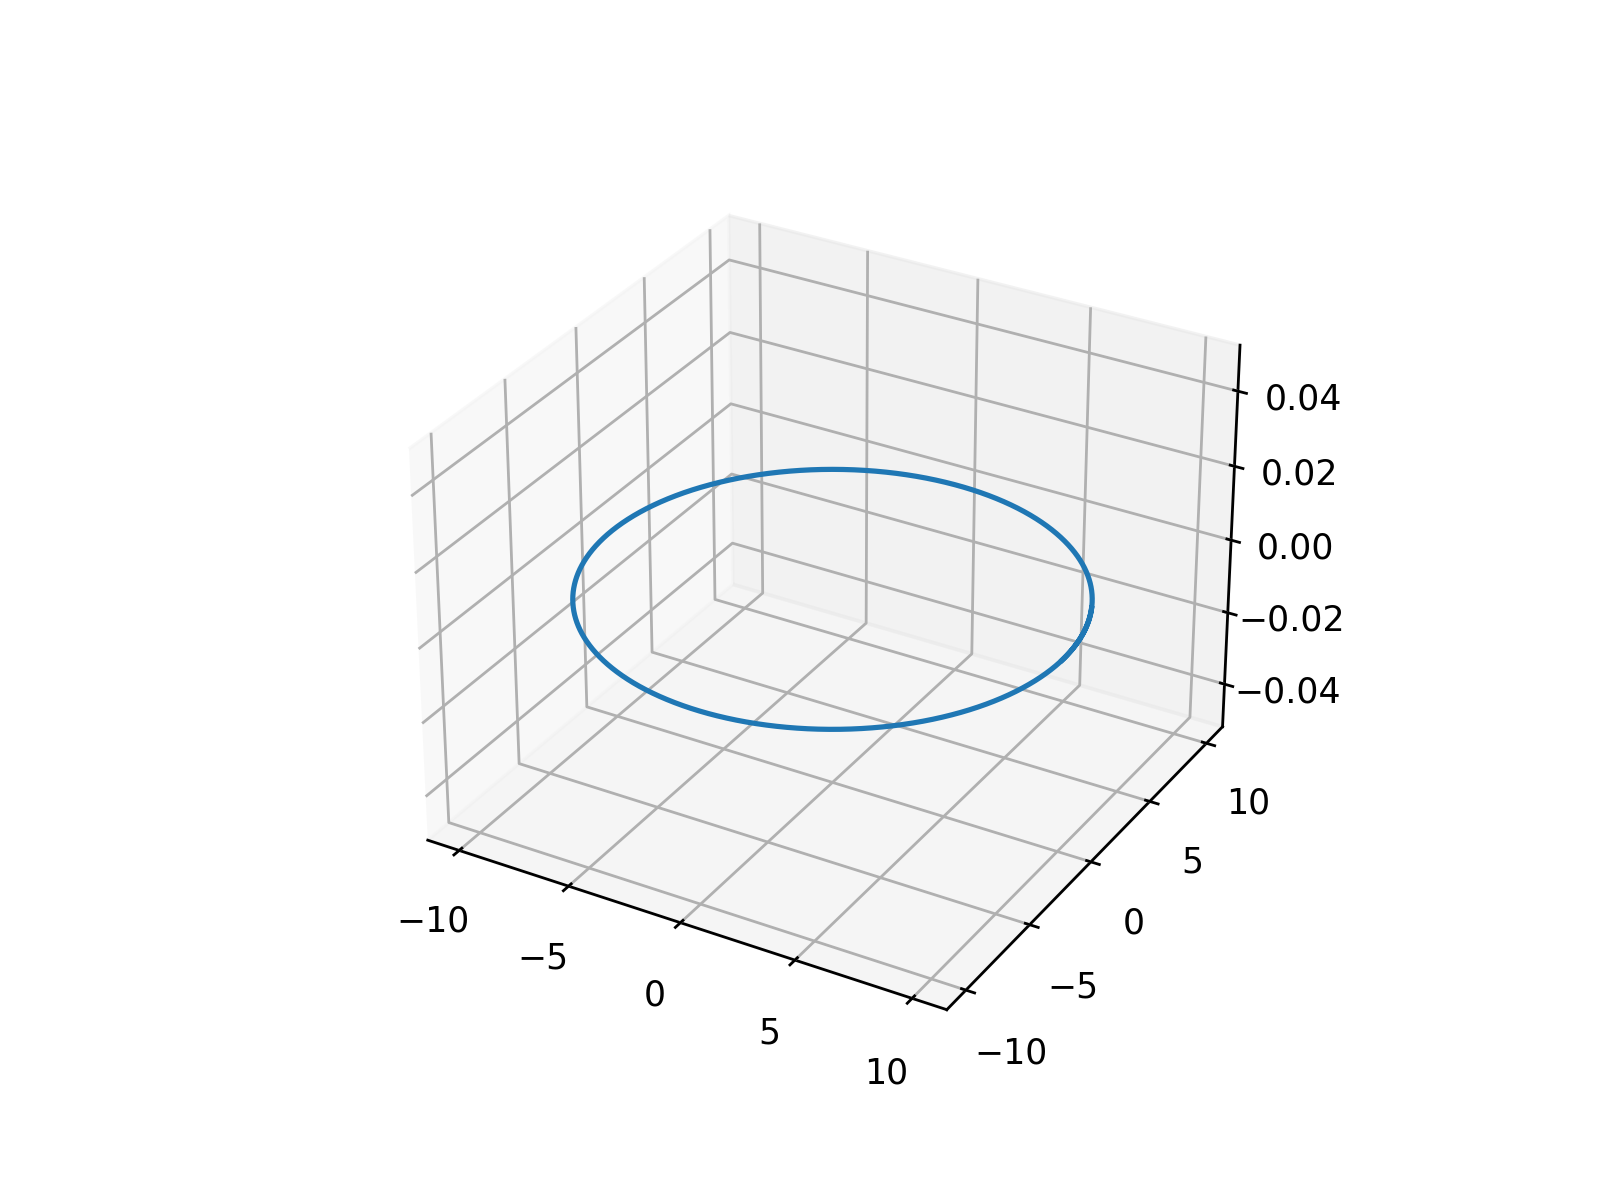

In [9]:
pos_num = res.y[:3]

fig = figure()
ax = fig.add_subplot(projection='3d')
ax.plot(pos_num[0], pos_num[1], pos_num[2])

# Neural network to solve the ODE

## Nondimensionalization

The equation of motion can be formulated as the ODE
$$
\frac{d^2 \vec{r}}{d t^2} = - \frac{GM}{r^3} \vec{r}
\tag{1}
$$

With the initial condition
$$
\vec{r}(t_0) = (R, 0, 0)^T, \frac{d \vec{r}} {dt}(t_0) = (0, V, 0)^T
\tag{2}
$$


Make the substitution
$$
t = t_c \tau, \vec{r} = r_c \vec{\phi}
\tag{3}
$$

We have
$$
\frac{d}{dt^2} = \frac{1}{t_c^2} \frac{d}{d\tau^2}
\tag{4}
$$

Apply (3) into (1) gives
$$
\frac{r_c}{t_c^2} \frac{d^2 \vec{\phi}}{d \tau^2} =  - \frac{GM}{r_c^3 \phi^3} r_c \vec{\phi}
\tag{5}
$$
After simplification, the ODE becomes
$$
\frac{d^2 \vec{\phi}}{d \tau^2} =  - \frac{ \vec{\phi} }{\phi^3} \frac{GM t_c^2}{r_c^3}
\tag{6}
$$
With the initial condition
$$
r_c \vec{\phi}(t_c \tau_0 = t_0) = (R, 0, 0)^T, \frac{r_c}{t_c} \frac{d\vec{\phi}}{d\tau}(t_c \tau_0 = t_0) = (0, V, 0)^T
\tag{7}
$$
or
$$
\vec{\phi}(\tau_0) = (\frac{R}{r_c}, 0, 0)^T, \frac{d\vec{\phi}}{d\tau}(\tau_0) = (0, \frac{V t_c}{r_c}, 0)^T
\tag{8}
$$


Now we decide the constants $r_c$ and $t_c$, if we choose
$$
r_c = R, t_c = \sqrt{\frac {R^3}{GM}}
\tag{9}
$$
Then (6) and (7) become
$$
\frac{d^2 \vec{\phi}}{d \tau^2} =  - \frac{\vec{\phi} }{\phi^3}
\tag{10}
$$
and
$$
\vec{\phi}(\tau_0) = (1, 0, 0)^T, \frac{d\vec{\phi}}{d\tau}(\tau_0) = (0, 1, 0)^T
\tag{11}
$$
Eqs (10) and (11) are the nondimensionalized ODE and the initial condition.



In [10]:
rc = R
tc = sqrt(R**3 / gm)

# time scalling
def t2tau(t):
    return t / tc

def tau2t(tau):
    return tc * tau

# position scalling
def r2phi(r):
    return r / rc

def phi2r(phi):
    return rc * phi

# velocity scalling
def v2psi(v):
    return v * tc / rc

def psi2v(psi):
    return psi * rc / tc

In [11]:
init_cond = torch.tensor([
    1, 0, 0,
    0, 1, 0,
])

In [12]:
tau_0 = torch.tensor(t2tau(t0))
tau_n = torch.tensor(t2tau(tn))
taus  = torch.tensor(t2tau(ts))

In [13]:
def eq_of_mo_neuro(phi_x, phi_y, phi_z, tau):
    phi = torch.sqrt(phi_x*phi_x + phi_y*phi_y + phi_z*phi_z)
    return [
        diff(phi_x, tau, 2) + phi_x / phi ** 3,
        diff(phi_y, tau, 2) + phi_y / phi ** 3,
        diff(phi_z, tau, 2) + phi_z / phi ** 3,
    ]

In [14]:
# specify the initial conditions
init_vals_lv = [
    IVP(tau_0, init_cond[0], init_cond[3]),
    IVP(tau_0, init_cond[1], init_cond[4]),
    IVP(tau_0, init_cond[2], init_cond[5]),
]

# layers = [32] * 2
# nets_lv = [
#     FCNN(n_input_units=1, n_output_units=1, hidden_units=layers, actv=SinActv),
#     FCNN(n_input_units=1, n_output_units=1, hidden_units=layers, actv=SinActv),
#     FCNN(n_input_units=1, n_output_units=1, hidden_units=layers, actv=SinActv),
# ]

<IPython.core.display.Javascript object>


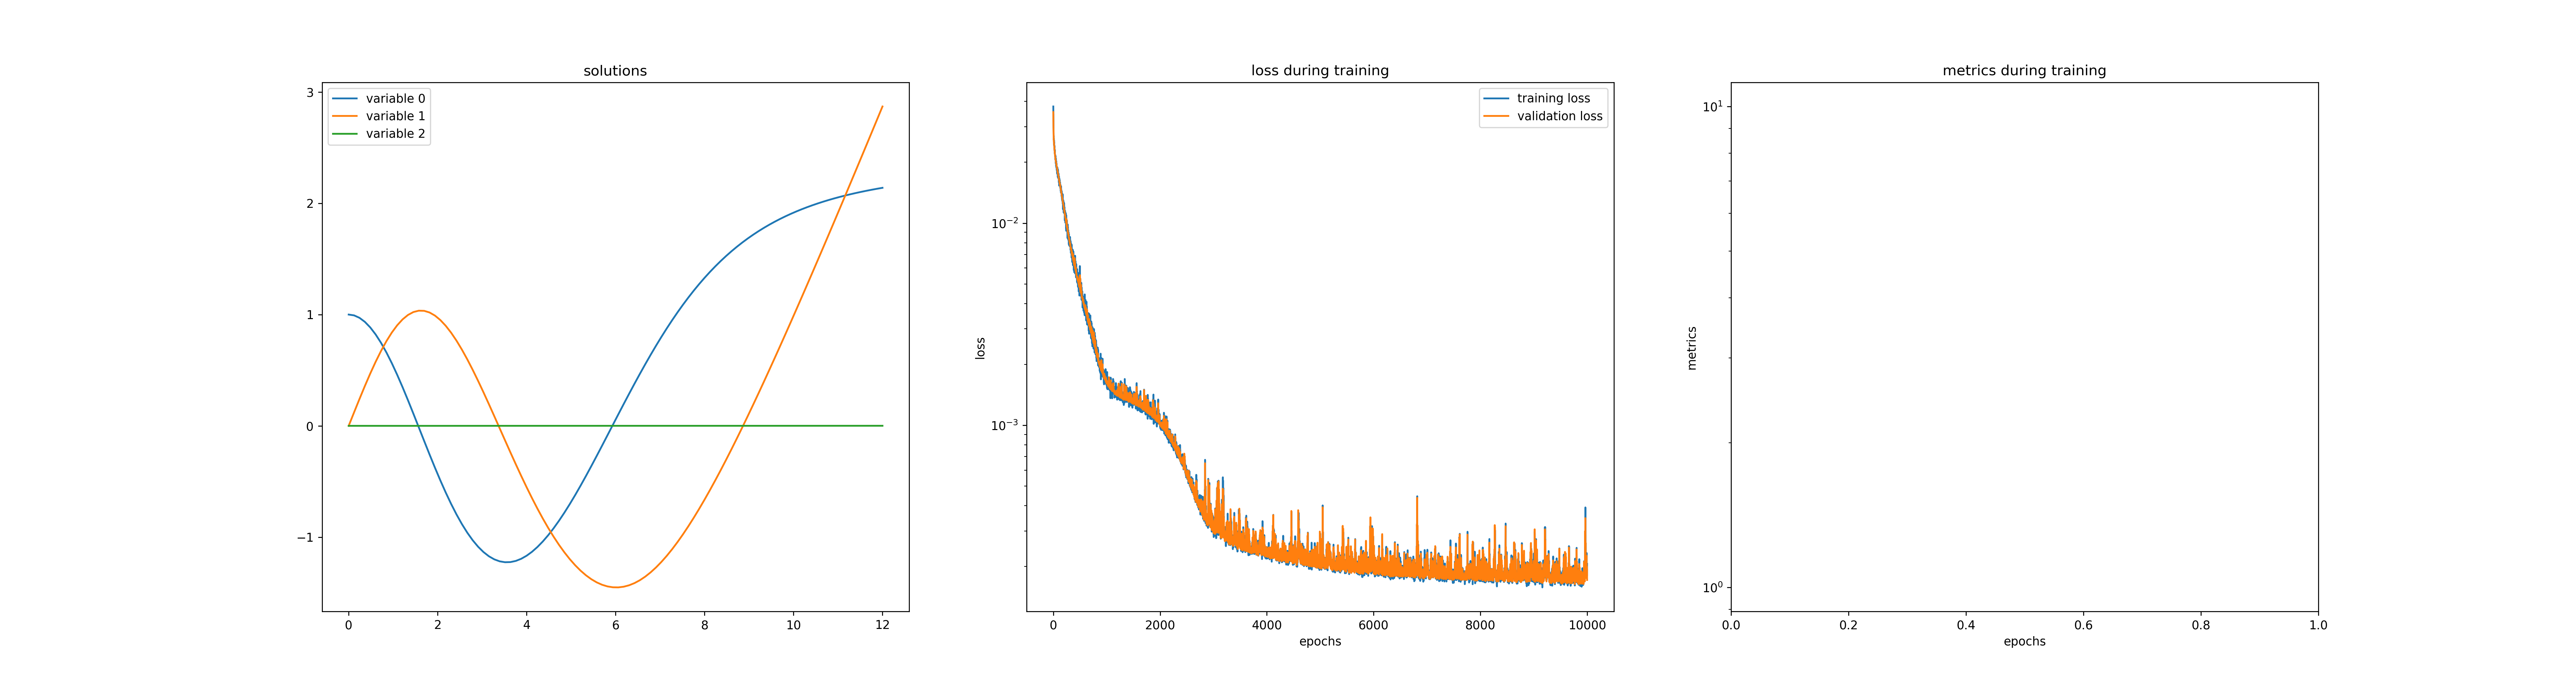

CPU times: user 5min 1s, sys: 3.08 s, total: 5min 4s
Wall time: 5min 9s


In [15]:
%%time
monitor = Monitor1D(t_min=0.0, t_max=12.0, check_every=100)
monitor_callback = monitor.to_callback()

solver = Solver1D(
    ode_system=eq_of_mo_neuro,
    conditions=init_vals_lv,
    t_min=tau_0, t_max=tau_n,
#     nets=nets_lv
)

# Fit the solver (i.e., train the neural networks)
res = solver.fit(max_epochs=10000, callbacks=[monitor_callback])

# Get the solution
solution_lv = solver.get_solution()

In [16]:
phis = array(solution_lv(taus, to_numpy=True))

pos_neuro = phi2r(phis)

<IPython.core.display.Javascript object>


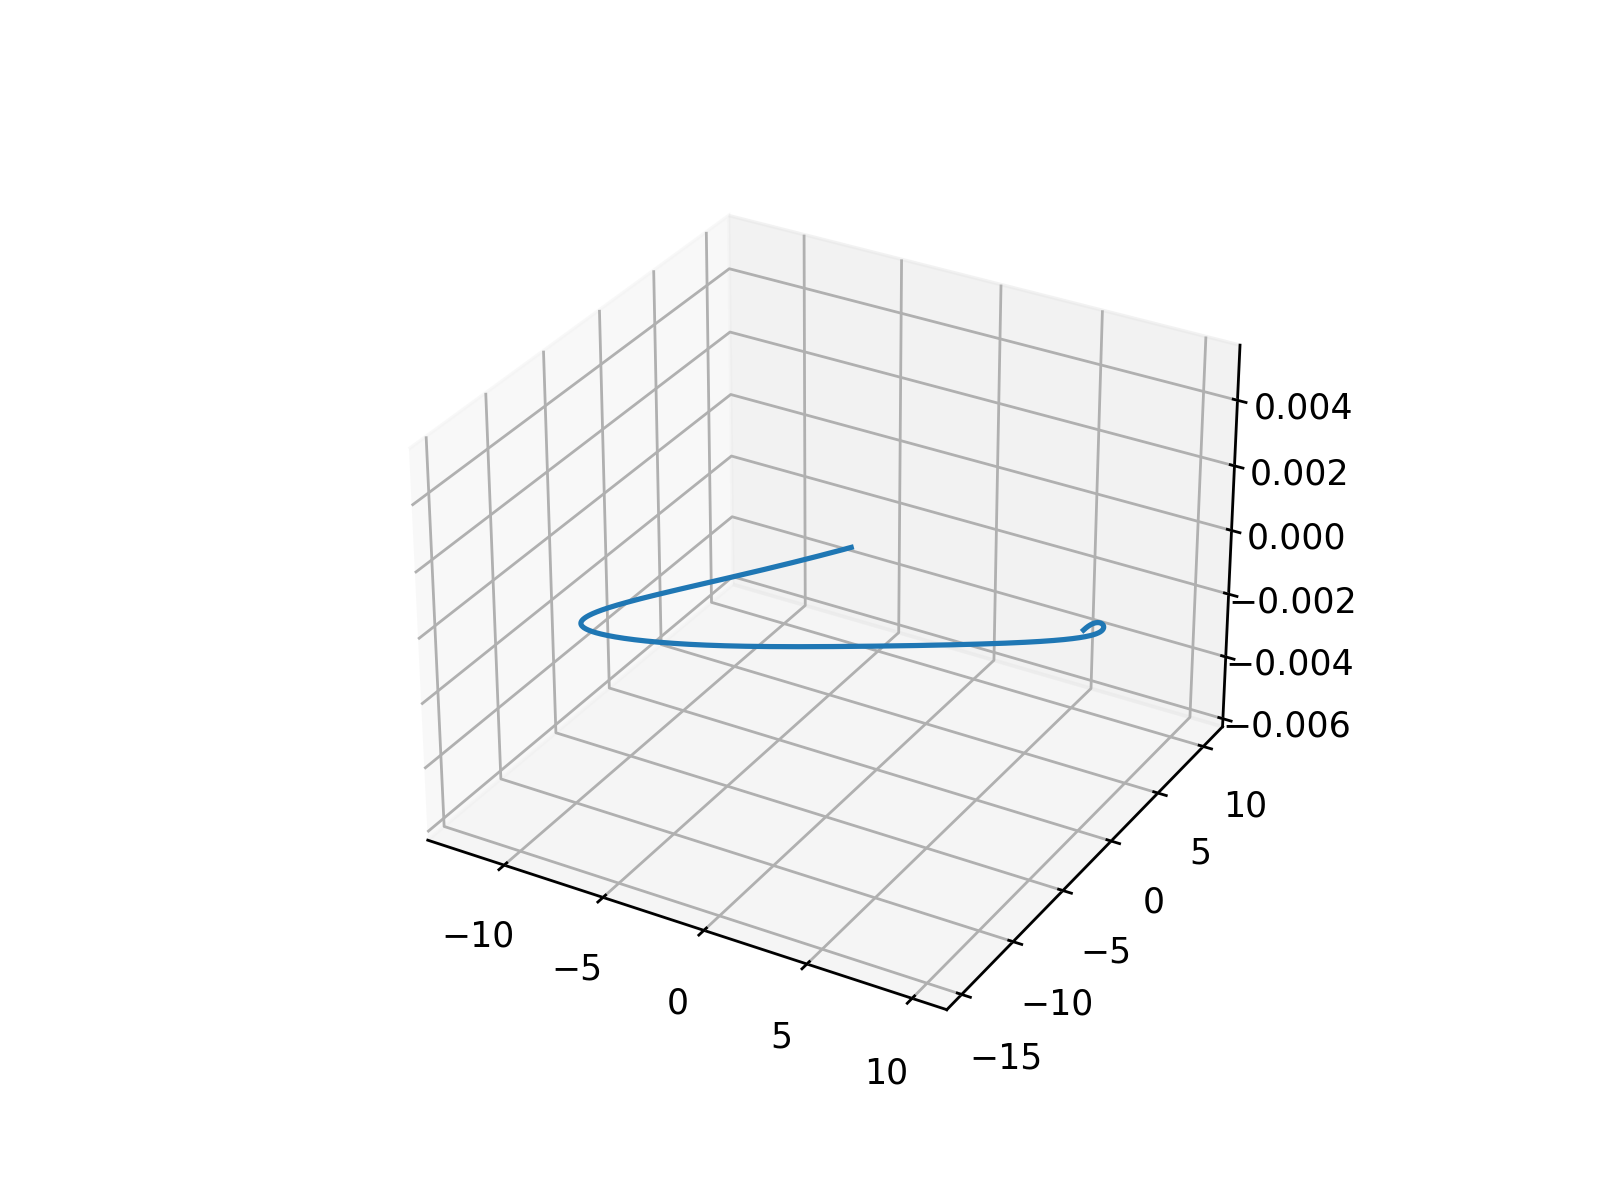

In [17]:
fig = figure()
ax = fig.add_subplot(projection='3d')
ax.plot(pos_neuro[0], pos_neuro[1], pos_neuro[2])

# Comparision

In [18]:
delta = pos_num - pos_neuro

In [19]:
ts.shape, delta.shape

((4321,), (3, 4321))

<IPython.core.display.Javascript object>


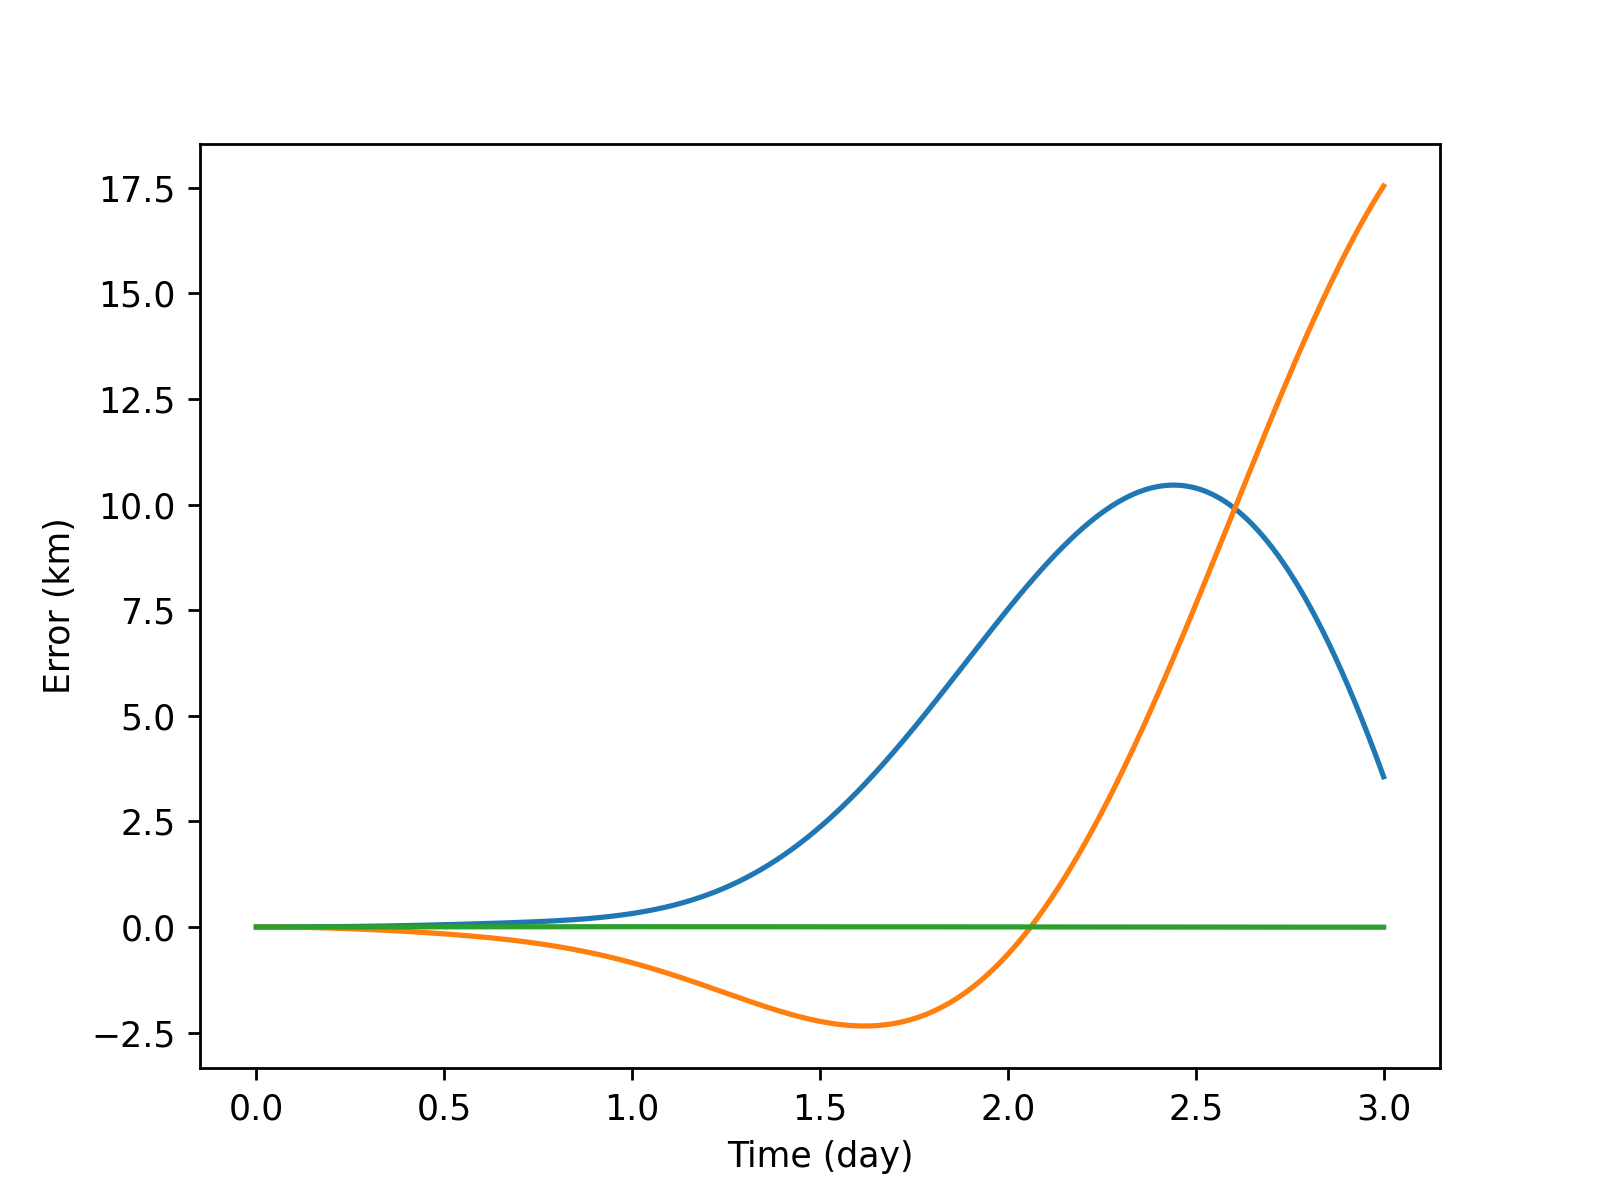

Text(0.5, 0, 'Time (day)')

In [20]:
days = (ts - ts[0]) / 86400

figure()
plot(days, delta[0])
plot(days, delta[1])
plot(days, delta[2])

ylabel('Error (km)')
xlabel('Time (day)')